In [2]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
from sklearn.decomposition import PCA

sys.path.append("/home/david/Documentos/Codes/postgresql")
sys.path.append("../utils/")

from graphs import *
from utils_psql import *

import warnings
warnings.filterwarnings("ignore")


import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#009473","#FF6F61"])


%load_ext autoreload
%autoreload 2

### Conectar con la base de datos

In [27]:
path_env = '/home/david/Documentos/Codes/postgresql/.env'

db = ConnectDB(path_env)

query_indices = """SELECT {tabla1}.name, {tabla1}.folder, {tabla2}.acift, 
            {tabla2}.adi, {tabla2}.beta, {tabla2}.m, {tabla2}.np, 
            {tabla2}.h, {tabla2}.aei, {tabla2}.ndsi  
            FROM {tabla1}
            JOIN {tabla2}
            ON {tabla1}.cod_audio = {tabla2}.cod_audio
            WHERE {tabla1}.folder = '{folder}';
        """

query_psd = """SELECT audios.name, audios.folder, {tabla2}.psd, {tabla2}.frequency
               FROM audios
               JOIN {tabla2}
               ON audios.cod_audio = {tabla2}.cod_audio
               WHERE audios.folder = '{folder1}' 
               OR audios.folder = '{folder2}';"""

query_coh = """SELECT * FROM coherence 
                WHERE folder1 = '{folder}A' 
                AND  folder2 = '{folder}S';"""

### Distribuciones indices

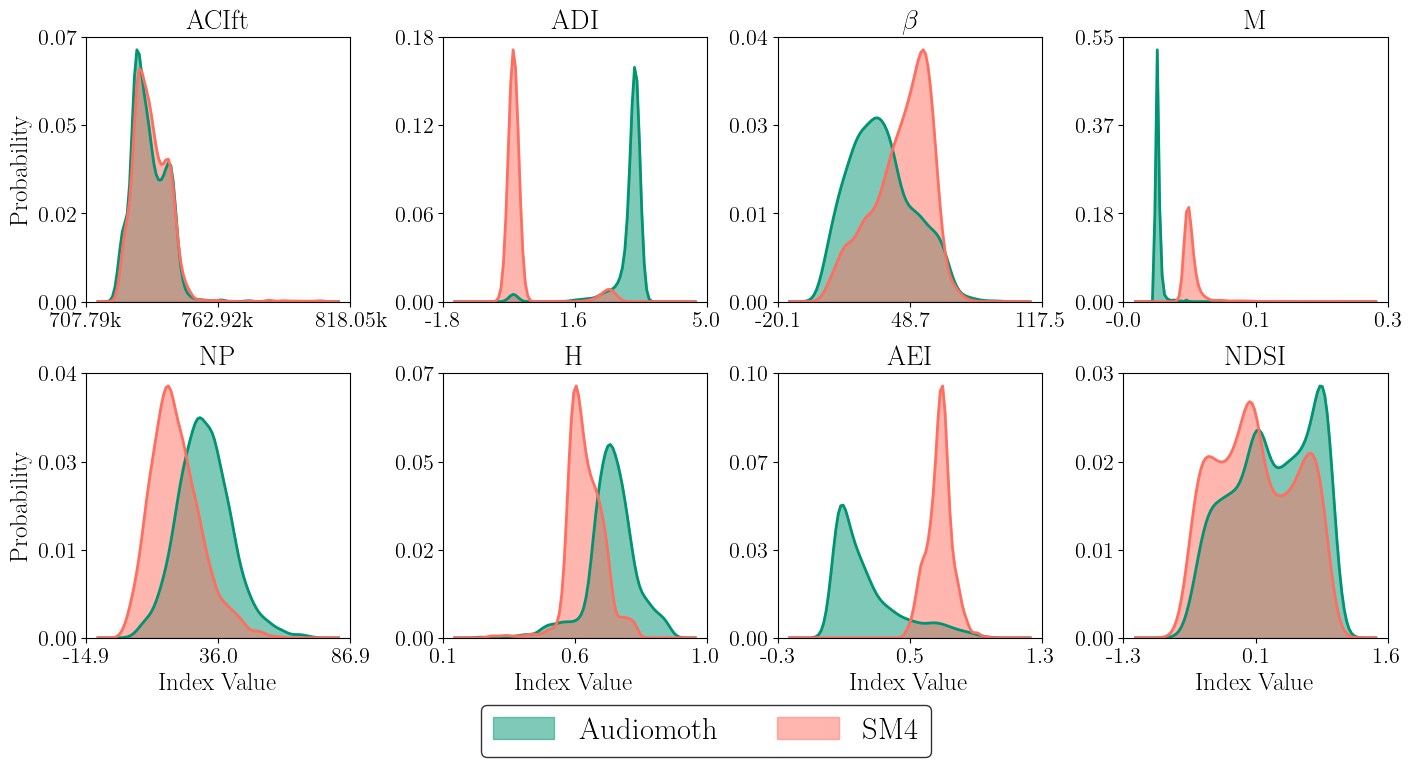

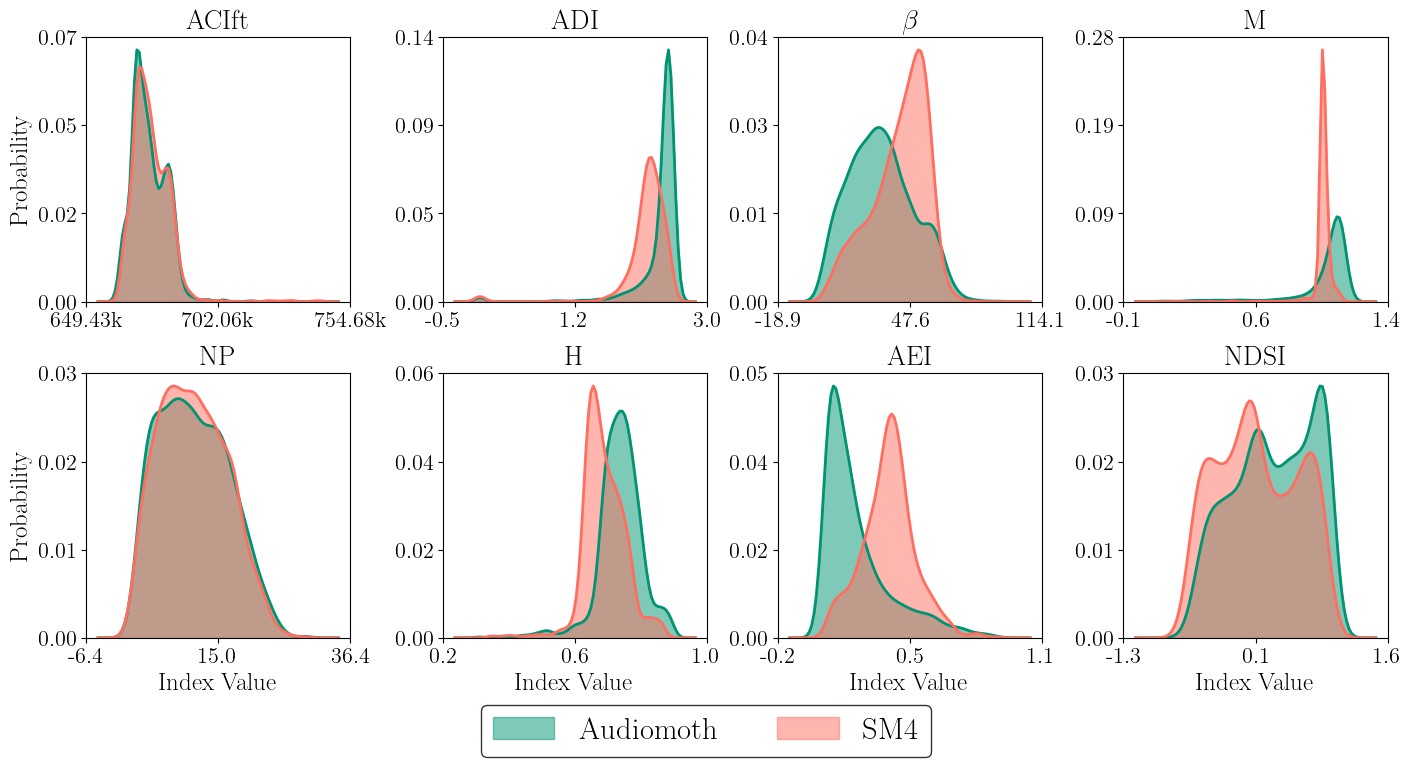

In [25]:
point = 'S2'

fig = graph_pdf(query_indices,tabla1='audios', tabla2='raw_indices',point= point, db=db, show=False )
#fig.savefig(f'/home/david/Documents/Codes/indices-hardware/indices/results/figuresv1/indices_raw_{point}.pdf',bbox_inches='tight')


fig = graph_pdf(query_indices,tabla1='audios', tabla2='processed_indices',point= point, db=db, show=False)
#fig.savefig(f'/home/david/Documents/Codes/indices-hardware/indices/results/figuresv1/indices_pro_{point}.pdf',bbox_inches='tight')

### PSD

102 103


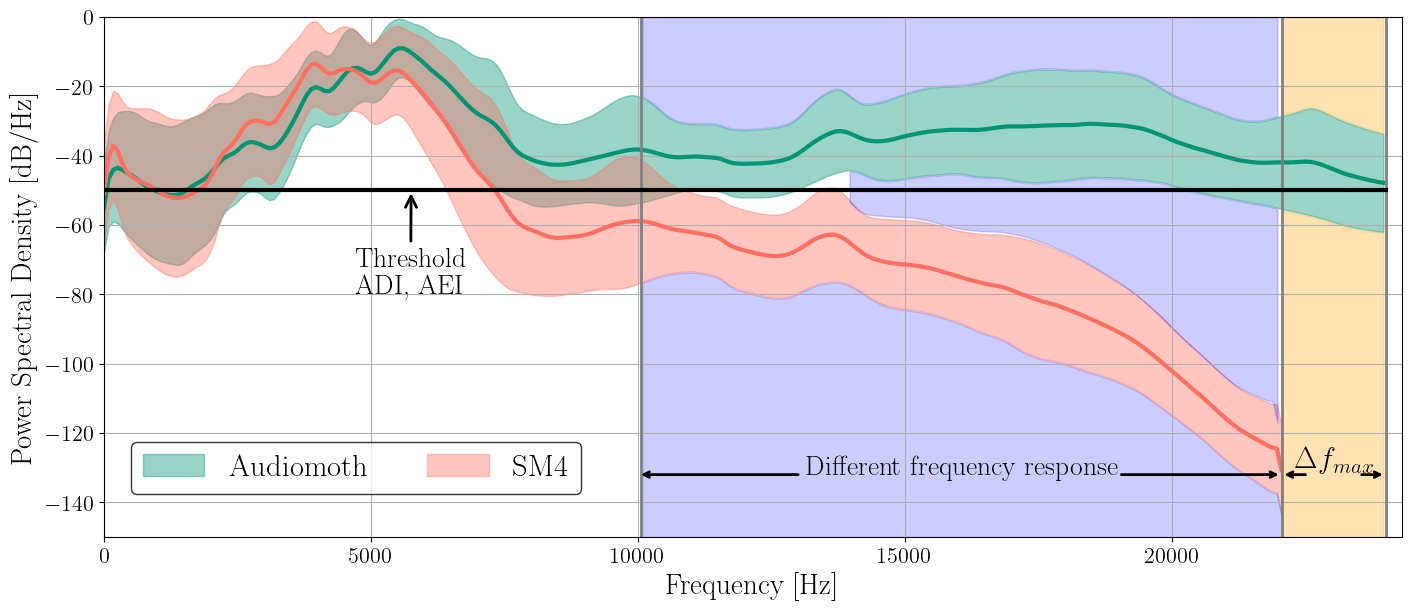

In [32]:
db.execute(query_psd.format(folder1='G60A', folder2='G60A',tabla2='raw_psd'))
dfa_psd = db.fetchall()

db.execute(query_psd.format(folder1='G60S', folder2='G60S',tabla2='raw_psd'))
dfs_psd = db.fetchall()

fig = plot_psd_comparison(dfa_psd, dfs_psd)
fig.savefig('/home/david/Documentos/Codes/codes-indices-recorders/results/figures/frequency_response_g60.pdf',bbox_inches='tight')

In [ ]:
db.execute(query_psd.format(folder1='G21A', folder2='G21A',tabla2='raw_psd'))
dfa_psd = db.fetchall()

db.execute(query_psd.format(folder1='G21S', folder2='G21S',tabla2='raw_psd'))
dfs_psd = db.fetchall()

fig = plot_psd_comparison(dfa_psd, dfs_psd)
fig.savefig('/home/david/Documents/Codes/indices-hardware/indices/results/figuresv1/frequency_response.pdf',bbox_inches='tight')

### Coherence

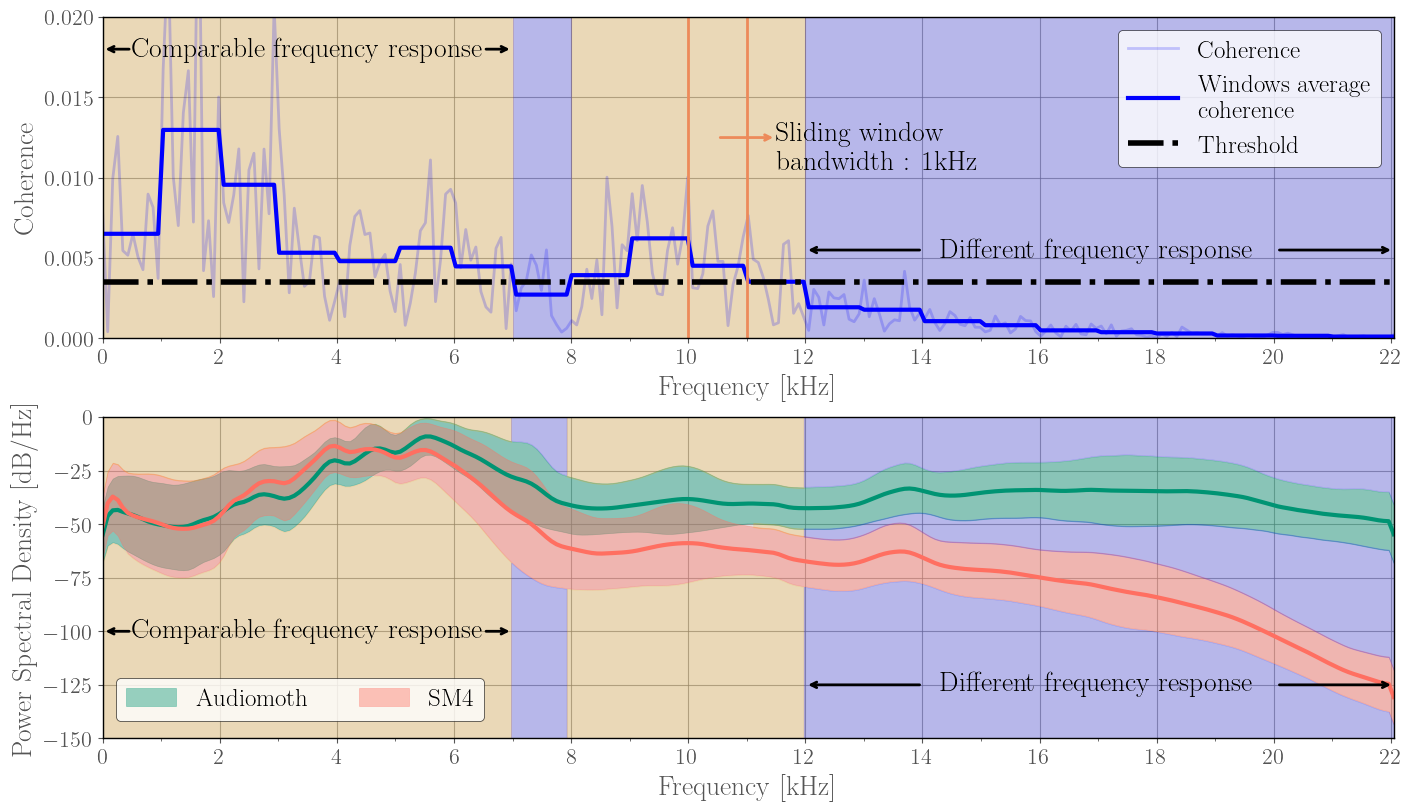

In [28]:
df_coh = torch.load('../results/df_coherence.pth')



def get_coherence(df, cols = ['sxx','syy','sxy']):
    Pxx = df[cols[0]].mean()
    Pyy = df[cols[1]].mean()
    Pxy = df[cols[2]].mean()

    coh = np.abs(Pxy) / (np.sqrt(Pxx) * np.sqrt(Pyy))
    freq = np.array(df_coh.freq[0])
    
    return coh, freq
    
def graph_windows_psd(df1, df2, ax,fig, point):
    d1 = np.array([ 20*np.log10(np.array(x)/np.array(x).max()) for x in df1.psd.values ])
    d2 = np.array([ 20*np.log10(np.array(x)/np.array(x).max()) for x in df2.psd.values ])

    psd1 = np.mean(d1,axis=0)
    psd2 = np.mean(d2,axis=0)

    std1 = np.std(d1,axis=0)
    std2 = np.std(d2,axis=0)

    freq1 = np.array(df1.iloc[0].freq)
    freq2 = np.array(df2.iloc[0].freq)

    liminf1 = psd1 - std1
    limsup1 = psd1 + std1

    ax.plot(freq1,psd1,linewidth=3,label ='Audiomoth',color='#009473')
    l1 = ax.fill_between(freq1, liminf1,limsup1, color='#009473', alpha=0.4)

    liminf2 = psd2 - std2
    limsup2 = psd2 + std2

    ax.plot(freq2,psd2,linewidth=3,label = 'SM4', color="#FF6F61")
    l2 = ax.fill_between(freq2, liminf2,limsup2, color='#FF6F61', alpha=0.4)

    if point == "G21":
        f1 = freq1[np.logical_and(freq1 >= 0, freq1 <= 7000)]
        limin1 = np.array([liminf1,liminf2]).min(axis=0)
        x1 = limin1[np.logical_and(freq1 >= 0, freq1 <= 7000)]-0.3
        ax.fill_between(f1, x1,[-160]*len(f1) ,color='orange', alpha=0.2)
        
        limsup1 = np.array([limsup1,limsup2]).max(axis=0)
        x2 = limsup1[np.logical_and(freq1 >= 0, freq1 <= 7000)]-0.3
        ax.fill_between(f1, x2,[0]*len(f1) ,color='orange', alpha=0.2)
        
        ######################
        
        f2 = freq1[np.logical_and(freq1 >= 6900, freq1 <= 8000)]
        limin1 = np.array([liminf1,liminf2]).min(axis=0)
        x1 = limin1[np.logical_and(freq1 >= 6900, freq1 <= 8000)]-0.3
        ax.fill_between(f2, x1,[-160]*len(f2) ,color='blue', alpha=0.2)
        
        limsup1 = np.array([limsup1,limsup2]).max(axis=0)
        x2 = limsup1[np.logical_and(freq1 >= 6900, freq1 <= 8000)]+0.3
        ax.fill_between(f2, x2,[0]*len(f2) ,color='blue', alpha=0.2)        
        
        ######################
        
        f3 = freq1[np.logical_and(freq1 >= 7900, freq1 <= 12000)]
        limin1 = np.array([liminf1,liminf2]).min(axis=0)
        x1 = limin1[np.logical_and(freq1 >= 7900, freq1 <= 12000)]-0.3
        ax.fill_between(f3, x1,[-160]*len(f3) ,color='orange', alpha=0.2)
        
        limsup1 = np.array([limsup1,limsup2]).max(axis=0)
        x2 = limsup1[np.logical_and(freq1 >= 7900, freq1 <= 12000)]-0.3
        ax.fill_between(f3, x2,[0]*len(f3) ,color='orange', alpha=0.2)

        f5 = freq1[np.logical_and(freq1 >= 11100, freq1 <= 12000)]
        limin1 = np.array([liminf1,liminf2]).max(axis=0)
        x1 = limin1[np.logical_and(freq1 >= 11100, freq1 <= 12000)]+0.3
        limsup11 = np.array([limsup1,limsup2]).min(axis=0)
        x4 = limsup11[np.logical_and(freq1 >= 11100, freq1 <= 12000)]-0.3
        ax.fill_between(f5, x1,x4 ,color='orange', alpha=0.2)
        
        ######################
        
        f4 = freq1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]
        limin2 = np.array([liminf1,liminf2]).min(axis=0)
        x1 = limin2[np.logical_and(freq1 >= 11900, freq1 <= 22050)]-0.3
        ax.fill_between(f4, x1,[-160]*len(f4) ,color='blue', alpha=0.2)
        
        limsup11 = np.array([limsup1,limsup2]).max(axis=0)
        x2 = limsup11[np.logical_and(freq1 >= 11900, freq1 <= 22050)]+0.3
        ax.fill_between(f4, x2,[0]*len(f4) ,color='blue', alpha=0.2)   
        
        f5 = freq1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]
        limin1 = np.array([liminf1,liminf2]).max(axis=0)
        
        x1 = limin1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]+0.3
        limsup11 = np.array([limsup1,limsup2]).min(axis=0)
        x2 = limsup11[np.logical_and(freq1 >= 11900, freq1 <= 22050)]-0.3
        ax.fill_between(f5, x1,x2 ,color='blue', alpha=0.2)
        

    else:
        f1 = freq1[np.logical_and(freq1 >= 0, freq1 <= 12000)]
        limin1 = np.array([liminf1,liminf2]).min(axis=0)
        x1 = limin1[np.logical_and(freq1 >= 0, freq1 <= 12000)]-0.3
        ax.fill_between(f1, x1,[-160]*len(f1) ,color='orange', alpha=0.2)
        
        limsup1 = np.array([limsup1,limsup2]).max(axis=0)
        x2 = limsup1[np.logical_and(freq1 >= 0, freq1 <= 12000)]-0.3
        ax.fill_between(f1, x2,[0]*len(f1) ,color='orange', alpha=0.2)
        
        ######################
        
        f2 = freq1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]
        limin1 = np.array([liminf1,liminf2]).min(axis=0)
        x1 = limin1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]-0.3
        ax.fill_between(f2, x1,[-160]*len(f2) ,color='blue', alpha=0.2)
        
        limsup1 = np.array([limsup1,limsup2]).max(axis=0)
        x2 = limsup1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]+0.3
        ax.fill_between(f2, x2,[0]*len(f2) ,color='blue', alpha=0.2)
        
        if point == "G60":
            f5 = freq1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]
            limin1 = np.array([liminf1,liminf2]).max(axis=0)
            x1 = limin1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]+0.3
            limsup1 = np.array([limsup1,limsup2]).min(axis=0)
            x2 = limsup1[np.logical_and(freq1 >= 11900, freq1 <= 22050)]-0.3
            ax.fill_between(f5, x1,x2 ,color='blue', alpha=0.2)
    
            f5 = freq1[np.logical_and(freq1 >= 10900, freq1 <= 12000)]
            limin1 = np.array([liminf1,liminf2]).max(axis=0)
            x1 = limin1[np.logical_and(freq1 >= 10900, freq1 <= 12000)]+0.3
            limsup1 = np.array([limsup1,limsup2]).min(axis=0)
            x2 = limsup1[np.logical_and(freq1 >= 10900, freq1 <= 12000)]-0.3
            ax.fill_between(f5, x1,x2 ,color='orange', alpha=0.2)
    
    labels = ["Audiomoth", "SM4"]
    fig.legend((l1,l2),labels, loc='lower left', bbox_to_anchor=(0.07, 0.09), ncol=len(labels), fontsize=18)

    ax.set_xlabel("Frequency [Hz]", fontsize=20)
    ax.set_ylabel("Power Spectral Density [dB/Hz]", fontsize=20)
    #fig.axes[0].spines[:].set_color("black")
    ax.set_xlim([0,22050])
    ax.set_ylim([-150,0])
    ax.grid()
    

        
    
    return fig
    
def plot_coherence(coh,freq, point,db=None,show=True):
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
    
    ax1.plot(freq,coh,linewidth=2, color="blue", label='Coherence',alpha =0.2)
    ax1.grid()
    ax1.legend(fontsize=22)
    ax1.set_xlim([0,22050])
    ax1.set_ylim([0,None])
    ax1.set_xlabel("Frequency [kHz]", fontsize=20)
    ax1.set_ylabel("Coherence", fontsize=20)
    ws_coh = []
    
    for i in range(0,22000,1000):
        wcoh = coh[np.logical_and(freq >= i, freq <= i+1000)]
        ws_coh.extend([wcoh.mean()]*len(wcoh))
        
        
    
    ws_coh.append(ws_coh[-1])
    ws_coh = np.array(ws_coh)
    
    ax1.plot(freq,ws_coh,linewidth=3, color="blue", label='Windows average \n coherence')
    #ax1.set_xlim([0,22050])
    #ax1.set_ylim([0,None])
    ws_th = np.quantile(ws_coh, 0.50)

    lgraph = []
    for i in range(0,22000,1000):
        wcoh = coh[np.logical_and(freq > i, freq <= i+1000)]
        
        if wcoh.mean() >= ws_th:
            lgraph.append(1) 
            #f = freq[np.logical_and(freq >= i , freq < i+1000)]
            #ax1.fill_between(f, [0]*len(f),[0.1]*len(f) ,color='orange', alpha=0.3)
            #ax1.plot([i,i],[0.03,0.1],linewidth=2, color='#0b986a')
            #ax2.fill_between(f, [0]*len(f),[-160]*len(f) ,color='orange', alpha=0.3)
            #ax2.plot([i,i],[0,-160],linewidth=2, color='#0b986a')
        else:
            lgraph.append(0)
            #f = freq[np.logical_and(freq >= i , freq < i+1000)]
            #ax1.fill_between(f, [0]*len(f),[0.1]*len(f) ,color='blue', alpha=0.2)
            #ax1.plot([i,i],[0.03,0.1],linewidth=2, color='#cb4c08')
            #ax2.fill_between(f, [0]*len(f),[-160]*len(f) ,color='blue', alpha=0.2)
            #ax2.plot([i,i],[0,-160],linewidth=2, color='#cb4c08')
            
    if point == "G21":
        f1 = [0,7000]
        f2 = [8000,12000]
        f3 = [7000,8000] 
        f4 = [12000, 22050]
        ax1.fill_between(f1, [0]*len(f1),[0.1]*len(f1) ,color='orange', alpha=0.2)
        ax1.fill_between(f2, [0]*len(f2),[0.1]*len(f2) ,color='orange', alpha=0.2)
        ax1.fill_between(f3, [0]*len(f3),[0.1]*len(f3) ,color='blue', alpha=0.2)
        ax1.fill_between(f4, [0]*len(f4),[0.1]*len(f4) ,color='blue', alpha=0.2)
    else:
        f1 = [0,12000]
        f2 = [12000,22050]
        ax1.fill_between(f1, [0]*len(f1),[0.1]*len(f1) ,color='orange', alpha=0.2)
        ax1.fill_between(f2, [0]*len(f2),[0.1]*len(f2) ,color='blue', alpha=0.2)
        

    ax1.plot([0,22050],[ws_th,ws_th],'-.',linewidth=4,label = 'Threshold',color='black')
    ax1.set_xlabel("Frequency [kHz]")
    ax2.set_xlabel("Frequency [kHz]")
    ax1.set_ylabel("Coherence", fontsize=20)
    ax1.legend(fontsize=18, loc='upper right')
    
    ###################################
    
    #db.execute(query_psd.format(folder1=f'{point}A', folder2=f'{point}A',tabla2='pro_psd'))
    #dfa_psd = db.fetchall()

    #db.execute(query_psd.format(folder1=f'{point}S', folder2=f'{point}S',tabla2='pro_psd'))
    #dfs_psd = db.fetchall()
    psd = torch.load("../results/camilo_psd_processed.pth")
    psd_df  = pd.DataFrame(psd['data'])
    psd_df.columns = ['name', 'folder', 'psd', 'freq']
    psd_df.psd = [x[0] for x in psd_df.psd]

    dfa_psd = psd_df.query('folder== "G60A"')
    dfs_psd = psd_df.query('folder== "G60S"')
    
    
    graph_windows_psd(dfa_psd, dfs_psd, ax2, fig, point)
    ax1.xaxis.set_major_locator(ticker.IndexLocator(base=2000,offset=0))
    ax1.xaxis.set_minor_locator(ticker.IndexLocator(base=2000,offset=1000))
    
    
    ax2.xaxis.set_major_locator(ticker.IndexLocator(base=2000,offset=0))
    ax2.xaxis.set_minor_locator(ticker.IndexLocator(base=2000,offset=1000))
    
    
    if point == "G21":
        ax1.text(14300,0.005,"Different frequency response", fontsize=20)
        ax1.annotate("",
                    xy=(22050,0.0055),
                    xytext=(20050,0.0055 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax1.annotate("",
                    xy=(12000,0.0055),
                    xytext=(14000,0.0055 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))


        ax1.text(500,0.0175,"Comparable frequency response", fontsize=20)
        ax1.annotate("",
                    xy=(7000,0.018),
                    xytext=(6500,0.018),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax1.annotate("",
                    xy=(0,0.018),
                    xytext=(500,0.018 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))


        ax1.plot([10000,10000],[0,0.03],'-',color='#ed8a5a',linewidth=2)
        ax1.plot([11000,11000],[0,0.03],'-',color='#ed8a5a',linewidth=2)

        ax1.text(11500,0.0105,"Sliding window \n bandwidth : 1kHz", fontsize=20, color='black')
        ax1.annotate("",
                    xy=(11500,0.0125),
                    xytext=(10500,0.0125 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="#ed8a5a",linewidth=2))
        ################################

        ax2.text(14300,-128,"Different frequency response", fontsize=20)
        ax2.annotate("",
                    xy=(22050,-125),
                    xytext=(20050,-125 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax2.annotate("",
                    xy=(12000,-125),
                    xytext=(14000,-125 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))



        ax2.text(500,-103,"Comparable frequency response", fontsize=20)
        ax2.annotate("",
                    xy=(7000,-100),
                    xytext=(6500,-100 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax2.annotate("",
                    xy=(0,-100),
                    xytext=(500,-100 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

    else:
        ax1.text(14300,0.005,"Different frequency response", fontsize=20)
        ax1.annotate("",
                    xy=(22050,0.0055),
                    xytext=(20050,0.0055 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax1.annotate("",
                    xy=(12000,0.0055),
                    xytext=(14000,0.0055 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))


        ax1.text(3000,0.0175,"Comparable frequency response", fontsize=20)
        ax1.annotate("",
                    xy=(12000,0.018),
                    xytext=(9500,0.018),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax1.annotate("",
                    xy=(0,0.018),
                    xytext=(2500,0.018 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))


        ax1.plot([10000,10000],[0,0.03],'-',color='#ed8a5a',linewidth=2)
        ax1.plot([11000,11000],[0,0.03],'-',color='#ed8a5a',linewidth=2)

        ax1.text(11500,0.0105,"Sliding window \n bandwidth : 1kHz", fontsize=20, color='black')
        ax1.annotate("",
                    xy=(11500,0.0125),
                    xytext=(10500,0.0125 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="#ed8a5a",linewidth=2))
        ################################

        ax2.text(14300,-128,"Different frequency response", fontsize=20)
        ax2.annotate("",
                    xy=(22050,-125),
                    xytext=(20050,-125 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax2.annotate("",
                    xy=(12000,-125),
                    xytext=(14000,-125 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))



        ax2.text(3000,-103,"Comparable frequency response", fontsize=20)
        ax2.annotate("",
                    xy=(12000,-100),
                    xytext=(9500,-100 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

        ax2.annotate("",
                    xy=(0,-100),
                    xytext=(2500,-100 ),
                    # xycoords="figure points",
                    arrowprops=dict(arrowstyle="->", color="black",linewidth=2))

    if show:
        fig.show()
        
    ax1.grid(color="grey", alpha=0.7)
    ax2.grid(color="grey", alpha=0.7)
    ax1.set_ylim(0,0.02)
    
    ax1.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22"])
    ax2.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22"])
    ax2.set_xlabel("Frequency [kHz]")
    ax1.spines[:].set_color("black")
    ax2.spines[:].set_color("black")
    
    return fig


point = 'G21'
df_temp = df_coh.query(f'folder1 == "{point}A" & folder2 == "{point}S"')     
coh1, freq1 = get_coherence(df_temp)

fig = plot_coherence(coh1,freq1,point,db=None,show=False)
fig.savefig('/home/david/Documentos/Codes/codes-indices-recorders/results/figures/coherence_g21.pdf',bbox_inches='tight')
fig.show()

In [38]:
df_coh

### Graficas Audios

In [5]:
from numpy.fft import fft, ifft

def analytic(x,n):
    N = n
    xf = fft(x)
    xf[1:N//2] *= 2
    if N % 2 == 1:
        xf[N//2] *= 2
    xf[N//2 + 1:] = 0
    xa = ifft(xf)
    assert np.allclose(xa.real, x)
    return xa

x,sr1 = torchaudio.load(f'/media/david/7316-1D94/datasets/camilo/G21A/G21A_20190520_190000.wav')
x = x.numpy()[0,0:sr1*10]

y,sr2 = torchaudio.load(f'/media/david/7316-1D94/datasets/camilo/G21S/164114_20190520_190000.wav')
y = y[0,0:sr2*10].numpy()

fig,ax = plt.subplots(2,2,figsize=(10,6))
ax = ax.ravel()
time1 = np.linspace(0, x.shape[0]/sr1, num=x.shape[0])
time2 = np.linspace(0, y.shape[0]/sr2, num=y.shape[0])

x2 = x/np.sqrt(np.mean(x**2))
y2 = y/np.sqrt(np.mean(y**2))

from scipy.fft import rfft, rfftfreq
from scipy.ndimage import gaussian_filter


def get_hilbert(signal,frate):
    # Compute the amplitude of the sound signal
    signalAmplitude = signal.astype(np.float64)**2

    # Filter the signal to remove very short-timed amplitude modulations (<= 1 ms)
    signalAmplitude = gaussian_filter(signalAmplitude, sigma=frate/1000)

    # Compute the frequency amplitude of the FFT signal
    tmpFreq = np.abs(rfft(signalAmplitude))

    # Get the associated practical frequency for this signal
    hzFreq = rfftfreq(signal.shape[0], d=1/frate)

    return tmpFreq, hzFreq

tmp, env1= get_hilbert(x,sr1)

ax[0].plot(tmp,env1)

#ax[0].plot(time1,x)
ax[1].plot(time2,y)


ax[2].plot(time1,x2)
ax[3].plot(time2,y2)

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)

ax[0].set_ylim(-0.23,0.23)
ax[1].set_ylim(-0.23,0.23)

ax[2].set_ylim(-10,10)
ax[3].set_ylim(-10,10)

plt.show()

RuntimeError: Failed to open the input "/media/david/7316-1D94/datasets/camilo/G21A/G21A_20190520_190000.wav" (No such file or directory).

### Comparar Sitios

In [38]:
db.execute(query_indices.format(tabla1='audios',tabla2='raw_indices',folder=f'G21A'))
dfa1 = db.fetchall()

db.execute(query_indices.format(tabla1='audios',tabla2='raw_indices',folder=f'G60A'))
dfa2 = db.fetchall()

db.execute(query_indices.format(tabla1='audios',tabla2='raw_indices',folder=f'G21S'))
dfs1 = db.fetchall()

db.execute(query_indices.format(tabla1='audios',tabla2='raw_indices',folder=f'G60S'))
dfs2 = db.fetchall()


indr = pd.concat([dfa1,dfa2,dfs1,dfs2])



db.execute(query_indices.format(tabla1='audios',tabla2='pro_indices',folder=f'G21A'))
dfa1 = db.fetchall()

db.execute(query_indices.format(tabla1='audios',tabla2='pro_indices',folder=f'G60A'))
dfa2 = db.fetchall()

db.execute(query_indices.format(tabla1='audios',tabla2='pro_indices',folder=f'G21S'))
dfs1 = db.fetchall()

db.execute(query_indices.format(tabla1='audios',tabla2='pro_indices',folder=f'G60S'))
dfs2 = db.fetchall()



indp = pd.concat([dfa1,dfa2,dfs1,dfs2])
indp

NameError: name 'db' is not defined

In [44]:
indr = pd.read_excel("../results/camilo_indices_v2.xlsx")
indp = pd.read_excel("../results/camilo_indices_processed_v2.xlsx")

indr.drop(columns=indr.columns[0], inplace=True)
indp.drop(columns=indp.columns[0], inplace=True)

indp

,name,folder,ACIft,ADI,BETA,M,NP,H,AEI,NDSI
0,G21A_20190530_094000.wav,G21A,662704.10,2.484764,35.178001,1.078222,5,0.886159,0.009396,0.280422
1,G21A_20190530_064400.wav,G21A,662641.30,2.471948,15.388259,1.070915,7,0.818174,0.089560,0.313706
2,G21A_20190530_090800.wav,G21A,664262.40,1.746529,3.066873,0.765543,5,0.589182,0.646257,0.128953
3,G21A_20190530_082000.wav,G21A,662203.30,2.472027,14.233543,1.061564,6,0.832087,0.089017,0.281488
4,G21A_20190530_080400.wav,G21A,662583.60,2.482657,21.850202,1.081417,6,0.851923,0.036943,0.289911
...,...,...,...,...,...,...,...,...,...,...
10921,164114_20211031_174500.wav,S1S,685363.70,1.783734,15.158991,1.000298,15,0.739323,0.569386,0.236458
10922,164114_20211031_171500.wav,S1S,680148.90,1.900457,28.460416,1.000589,9,0.609603,0.550616,0.232936
10923,164114_20211031_170000.wav,S1S,684535.94,1.974893,29.904966,0.997272,12,0.587668,0.522996,0.133983
10924,164114_20211031_163000.wav,S1S,680645.40,2.066715,29.538120,0.998729,13,0.699457,0.459727,0.259866


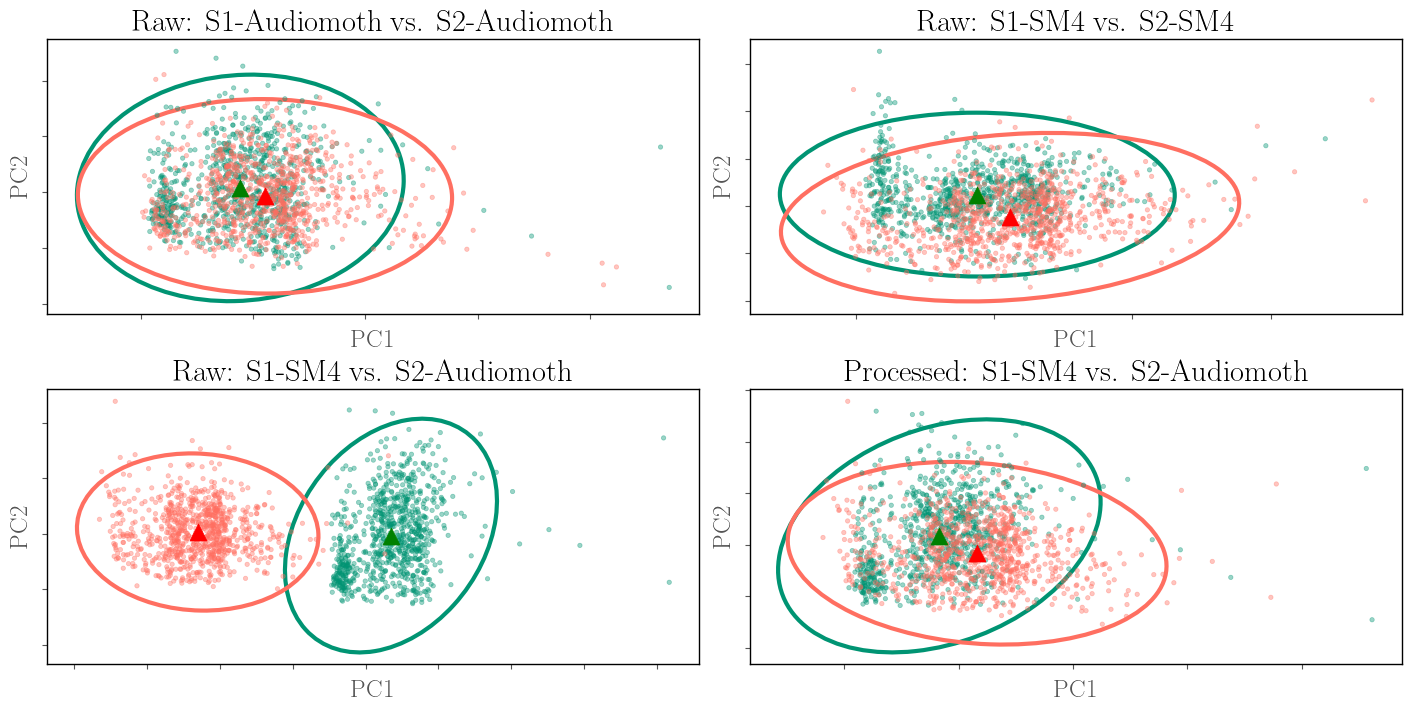

In [4]:
cl = [('G21A','G60A'),('G21S','G60S'),('G21A','G60S')]
title = [('S1-Audiomoth','S2-Audiomoth'),('S1-SM4','S2-SM4'),('S1-SM4','S2-Audiomoth')]

indr = pd.read_excel("../results/camilo_indices_v2.xlsx")
indp = pd.read_excel("../results/camilo_indices_processed_v2.xlsx")


fig, ax = plt.subplots(2,2, figsize=(14,7))
ax = ax.ravel()

count = 0
for c in cl:
    ind = indr.query(f'folder == "{c[0]}" | folder == "{c[1]}" ')
    cols = indr.columns
    

    pca = PCA(n_components=2)
    x1 = pca.fit_transform(ind[cols[3:]])
    ax[count].scatter(x1[:,0],x1[:,1], c=ind.folder.astype('category').cat.codes,cmap=cmap,  alpha=0.4,s=10)
    ax[count].set_title(f'Raw: {title[count][0]} vs. {title[count][1]}', fontsize=22)
    ax[count].set_xticklabels('')
    ax[count].set_yticklabels('')
    
    cx1 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 0])
    cy1 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 0])
    ax[count].scatter(cx1, cy1, marker='^', c='green', s=150)

    confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 0], 
                       x1[:,1][ind.folder.astype('category').cat.codes == 0], 
                       ax[count], edgecolor='#009473', linewidth=3, zorder=0)
    

    cx2 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 1])
    cy2 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 1])
    ax[count].scatter(cx2, cy2, marker='^', c='red', s=150)

    confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 1], 
                       x1[:,1][ind.folder.astype('category').cat.codes == 1], 
                       ax[count], edgecolor='#FF6F61', linewidth=3, zorder=0)

    ax[count].set_xlabel('PC1', fontsize=18)
    ax[count].set_ylabel('PC2', fontsize=18)
    ax[count].spines[:].set_color("black")
    ax[count].set_facecolor("white")
    ax[count].grid(alpha=0)

    
    
    
    count += 1
    
ind = indp.query(f'folder == "G21A" | folder == "G60S" ')
cols = indr.columns

pca = PCA(n_components=2)
x1 = pca.fit_transform(ind[cols[3:]])
ax[count].scatter(x1[:,0],x1[:,1], c=ind.folder.astype('category').cat.codes,cmap=cmap,  alpha=0.4,s=10)
ax[count].set_title(f'Processed: S1-SM4 vs. S2-Audiomoth', fontsize=22)

cx1 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 0])
cy1 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 0])
ax[count].scatter(cx1, cy1, marker='^', c='green', s=150)

confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 0], 
                    x1[:,1][ind.folder.astype('category').cat.codes == 0], 
                    ax[count], edgecolor='#009473', linewidth=3, zorder=0)


cx2 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 1])
cy2 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 1])
ax[count].scatter(cx2, cy2, marker='^', c='red', s=150)

confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 1], 
                    x1[:,1][ind.folder.astype('category').cat.codes == 1], 
                    ax[count], edgecolor='#FF6F61', linewidth=3, zorder=0)

ax[count].set_xticklabels('')
ax[count].set_yticklabels('')
ax[count].set_xlabel('PC1', fontsize=18)
ax[count].set_ylabel('PC2', fontsize=18)
ax[count].spines[:].set_color("black")
ax[count].set_facecolor("white")
ax[count].grid(alpha=0)

fig.savefig('/home/david/Documentos/Codes/codes-indices-recorders/results/figures/compare_locations.pdf',bbox_inches='tight')

fig.show()


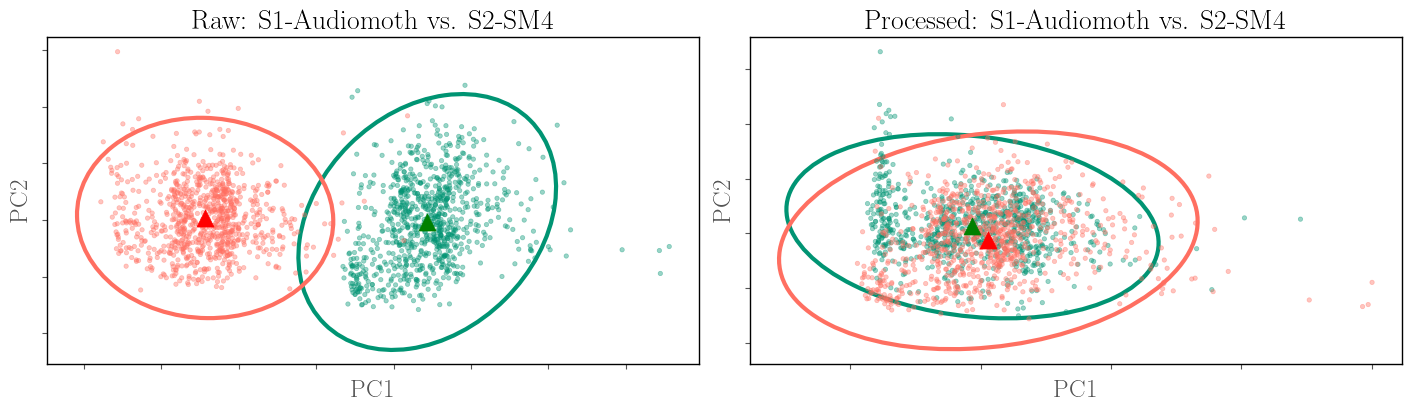

In [5]:
cl = [('G60A','G60S')]
title = [('S1-Audiomoth','S2-SM4')]

indr = pd.read_excel("../results/camilo_indices_v2.xlsx")
indp = pd.read_excel("../results/camilo_indices_processed_v2.xlsx")


fig, ax = plt.subplots(1,2, figsize=(14,4))
ax = ax.ravel()

count = 0
for c in cl:
    ind = indr.query(f'folder == "{c[0]}" | folder == "{c[1]}" ')
    cols = indr.columns
    

    pca = PCA(n_components=2)
    x1 = pca.fit_transform(ind[cols[3:]])
    ax[count].scatter(x1[:,0],x1[:,1], c=ind.folder.astype('category').cat.codes,cmap=cmap,  alpha=0.4,s=10)
    ax[count].set_title(f'Raw: {title[count][0]} vs. {title[count][1]}', fontsize=20)
    ax[count].set_xticklabels('')
    ax[count].set_yticklabels('')
    
    cx1 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 0])
    cy1 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 0])
    ax[count].scatter(cx1, cy1, marker='^', c='green', s=150)

    confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 0], 
                       x1[:,1][ind.folder.astype('category').cat.codes == 0], 
                       ax[count], edgecolor='#009473', linewidth=3, zorder=0)
    

    cx2 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 1])
    cy2 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 1])
    ax[count].scatter(cx2, cy2, marker='^', c='red', s=150)

    confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 1], 
                       x1[:,1][ind.folder.astype('category').cat.codes == 1], 
                       ax[count], edgecolor='#FF6F61', linewidth=3, zorder=0)

    ax[count].set_xlabel('PC1', fontsize=18)
    ax[count].set_ylabel('PC2', fontsize=18)
    ax[count].spines[:].set_color("black")
    ax[count].set_facecolor("white")
    ax[count].grid(alpha=0)

    
    
    
    count += 1
    
ind = indp.query(f'folder == "G21S" | folder == "G60A" ')
cols = indr.columns

pca = PCA(n_components=2)
x1 = pca.fit_transform(ind[cols[3:]])
ax[count].scatter(x1[:,0],x1[:,1], c=ind.folder.astype('category').cat.codes,cmap=cmap,  alpha=0.4,s=10)
ax[count].set_title(f'Processed: S1-Audiomoth vs. S2-SM4', fontsize=20)

cx1 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 0])
cy1 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 0])
ax[count].scatter(cx1, cy1, marker='^', c='green', s=150)

confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 0], 
                    x1[:,1][ind.folder.astype('category').cat.codes == 0], 
                    ax[count], edgecolor='#009473', linewidth=3, zorder=0)


cx2 = np.mean(x1[:,0][ind.folder.astype('category').cat.codes == 1])
cy2 = np.mean(x1[:,1][ind.folder.astype('category').cat.codes == 1])
ax[count].scatter(cx2, cy2, marker='^', c='red', s=150)

confidence_ellipse(x1[:,0][ind.folder.astype('category').cat.codes == 1], 
                    x1[:,1][ind.folder.astype('category').cat.codes == 1], 
                    ax[count], edgecolor='#FF6F61', linewidth=3, zorder=0)

ax[count].set_xticklabels('')
ax[count].set_yticklabels('')
ax[count].set_xlabel('PC1', fontsize=18)
ax[count].set_ylabel('PC2', fontsize=18)
ax[count].spines[:].set_color("black")
ax[count].set_facecolor("white")
ax[count].grid(alpha=0)

fig.savefig('/home/david/Documentos/Codes/codes-indices-recorders/results/figures/compare_locations_extra.pdf',bbox_inches='tight')

fig.show()

### Comparacion temporal indices

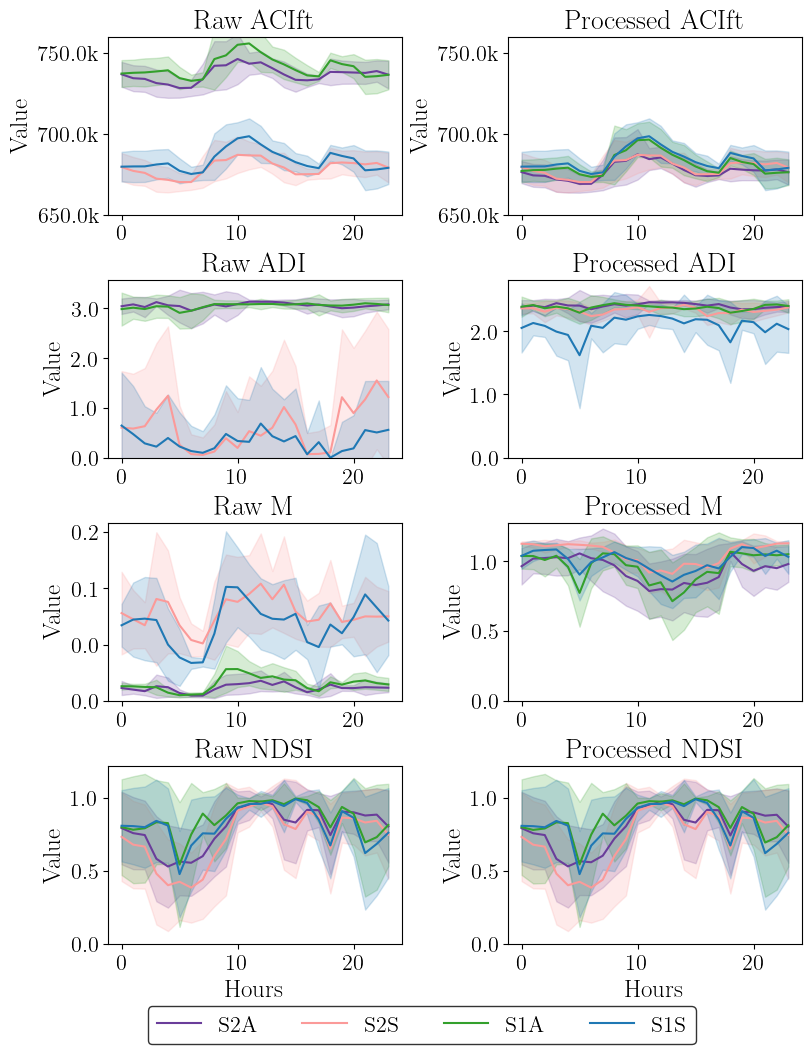

In [15]:
import sys
sys.path.append('/home/david/Documentos/Codes/codes-indices-recorders/graphics/')
from TemporalIndicesFigure import *

fig = TemporalIndicesFigure()
fig.plotFigureLinear(['acift','adi','m','ndsi'])


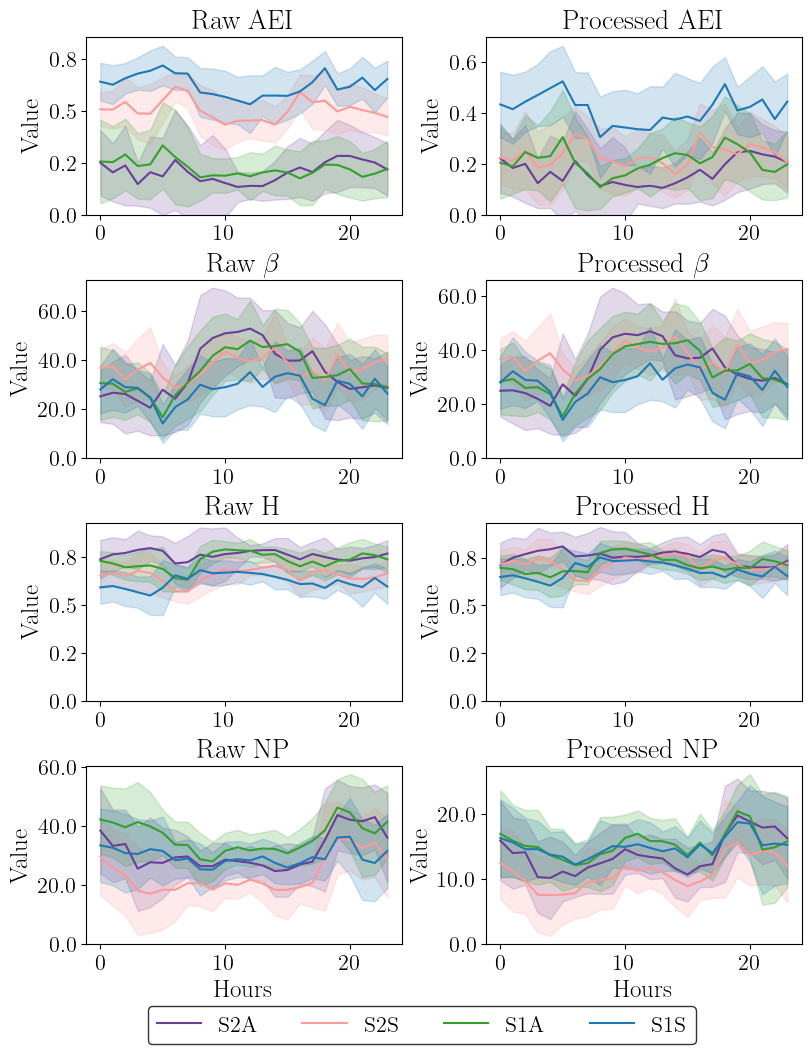

In [16]:
import sys
sys.path.append('/home/david/Documentos/Codes/codes-indices-recorders/graphics/')
from TemporalIndicesFigure import *

fig = TemporalIndicesFigure()
fig.plotFigureLinear(['aei','beta','h','np'])

### Comparacion Potencia de la señal

In [8]:
import sys
sys.path.append('/home/david/Código/codes-indices-recorders/graphics')
from PowerPlot import *

%load_ext autoreload
%autoreload 2

fig = PowerPlot()
fig.plotFigure()

ModuleNotFoundError: No module named 'utils_psql'

### PSD

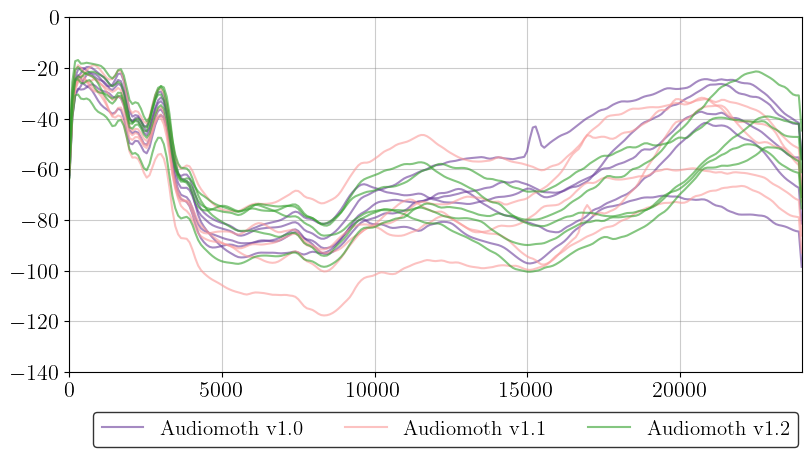

In [6]:
import sys
sys.path.append('/home/david/Documentos/Codes/codes-indices-recorders/graphics/')
from PsdBoxplot import *
fig = PsdBoxplot()
fig.plotFigure()